# Pre process codes

## import

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint



## trim and balance

In [2]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 
   


## pre processing

In [3]:
from skimage import exposure
import cv2
import numpy as np

# Preprocessing functions
from skimage import exposure
import cv2


def histogram_equalization(image):
  """
  Applies histogram equalization to enhance contrast.
  Args:
    image: The grayscale image.
  Returns:
    The equalized image.
  """
  equalized_image = exposure.equalize_adapthist(image ,  clip_limit=0.01)
  return equalized_image

def preprocessing_function(image):
    """
    Preprocesses knee X-ray images for CNN training.

    Args:
        image: The RGB image.
        contrast_method: "histogram_equalization" or "clahe_contrast_enhancement" (default: "histogram_equalization").

    Returns:
        The preprocessed image.
    """

    enhanced_image = histogram_equalization(image.copy())
    print("Enhanced Image Shape:", enhanced_image.shape)
    return enhanced_image





Enhanced Image Shape: (224, 224, 3)


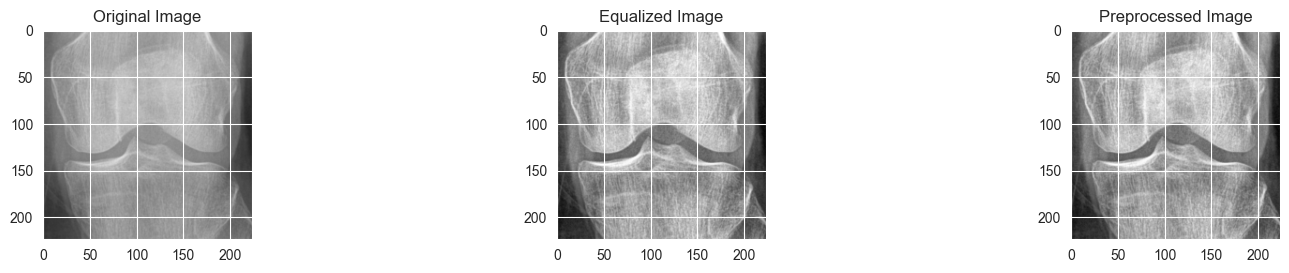

In [4]:
# Choose the desired contrast method
contrast_method = "histogram_equalization"  # Choose either "histogram_equalization" or "clahe_contrast_enhancement"

image = cv2.imread("F:\\music\\ex.PNG")

prep=preprocessing_function(image.copy())

# Apply ROI masking with Otsu's thresholding
# masked_image = otsu_thresholding_roi(image.copy())

# Apply histogram equalization
equalized_image = histogram_equalization(image.copy())

# Apply CLAHE contrast enhancement
# clahe_enhanced_image = clahe_contrast_enhancement(equalized_image)

# Visualize images at each step
# ...

# Visualize images at each step
plt.figure(figsize=(13, 6))

# Original Image
plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

# Masked Image (After ROI masking with Otsu's thresholding)
# plt.subplot(1, 5, 2)
# plt.imshow(masked_image, cmap='gray')
# plt.title("Masked Image")

# Equalized Image (After histogram equalization)
plt.subplot(1, 5, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")


# # CLAHE Enhanced Image
# plt.subplot(1, 5, 4)
# plt.imshow(clahe_enhanced_image, cmap='gray')
# plt.title("CLAHE Enhanced Image")

# preprocessed Enhanced Image
plt.subplot(1, 5, 5)
plt.imshow(prep, cmap='gray')
plt.title("Preprocessed Image")

plt.tight_layout()
plt.show()

# making dataframes

## make data frame

In [6]:
"D:\\Knee_data_Clahe\\cropped\\train"
IMGSZ= (224,224)
train_path="C:\\Users\\91745\\Documents\\Datasets\\knee\\train" 
test_path= "C:\\Users\\91745\\Documents\\Datasets\\knee\\test" 
valid_path="C:\\Users\\91745\\Documents\\Datasets\\knee\\val" 

# train_path="D:\\Knee_data_Clahe\\train" 
# test_path= "D:\\Knee_data_Clahe\\test" 
# valid_path= "D:\\Knee_data_Clahe\\val" 

# train_path="D:\\Knee_data_Clahe\\cropped\\train" 
# test_path= "D:\\Knee_data_Clahe\\cropped\\test" 
# valid_path= "D:\\Knee_data_Clahe\\cropped\\val" 

# train_path="D:\\cropped_knees\\train"
# test_path= "D:\\cropped_knees\\test" 
# valid_path="D:\\cropped_knees\\val" 



list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[] 
    classlist=os.listdir(d)   
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5839   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 802     
            Severe                  189     
Healthy  has the most images=  2286   Severe  has the least images=  189
average height=  224  average width=  224 aspect ratio=  1.0


## drop

In [7]:
# Drop specified classes

drop_classes = ["Healthy",'Moderate', 'Severe' ]

train_df = train_df[~train_df['labels'].isin(drop_classes)]
valid_df = valid_df[~valid_df['labels'].isin(drop_classes)]  
test_df = test_df[~test_df['labels'].isin(drop_classes)]

# Update the list of classes 
list_of_classes = [c for c in list_of_classes if c not in drop_classes]

# Re-calculate the total classes
class_count = len(list_of_classes)

# Re-count the images per class
groups = train_df.groupby('labels')  
for label in list_of_classes:
    group = groups.get_group(label) 
    print(label, len(group))

Doubtful 1046
Minimal 1516


## trim them 

In [8]:
max_samples=500
# since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


In [9]:
n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=IMGSZ # size of augmented images
train_df=balance(train_df, n, working_dir, img_size) 

Initial length of dataframe is  1000
Total Augmented images created=  0
Length of augmented dataframe is now  1000


C:\Users\91745\AppData\Local\Temp\ipykernel_19656\4003802151.py:63: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Fseries=pd.Series(aug_fpaths, name='filepaths')
C:\Users\91745\AppData\Local\Temp\ipykernel_19656\4003802151.py:64: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  Lseries=pd.Series(aug_labels, name='labels')


In [10]:
print (train_df['labels'].value_counts())

Doubtful    500
Minimal     500
Name: labels, dtype: int64


## train gen 

In [11]:
# Data augmentation and generators
img_size = IMGSZ
batch_size = 32
trgen = ImageDataGenerator(horizontal_flip=True,rotation_range=20,
                            vertical_flip=0.3, shear_range=0.08,
                            zoom_range=0.1, brightness_range=[0.9, 1.1],
#                             contrast_range=[0.9, 1.1],fill_mode='nearest'
                            )

t_and_v_gen = ImageDataGenerator()

train_gen = trgen.flow_from_dataframe(
    train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    preprocessing_function=preprocessing_function,
)

valid_gen = t_and_v_gen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
    preprocessing_function=preprocessing_function,
)

# Calculate test steps
length = len(test_df)
test_batch_size = sorted(
    [
        int(length / n)
        for n in range(1, length + 1)
        if length % n == 0 and length / n <= 80
    ],
    reverse=True,
)[0]
test_steps = int(length / test_batch_size)

test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=test_batch_size,
    preprocessing_function=preprocessing_function,
)

Found 1000 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Found 743 validated image filenames belonging to 2 classes.


# see the images 

## show images "

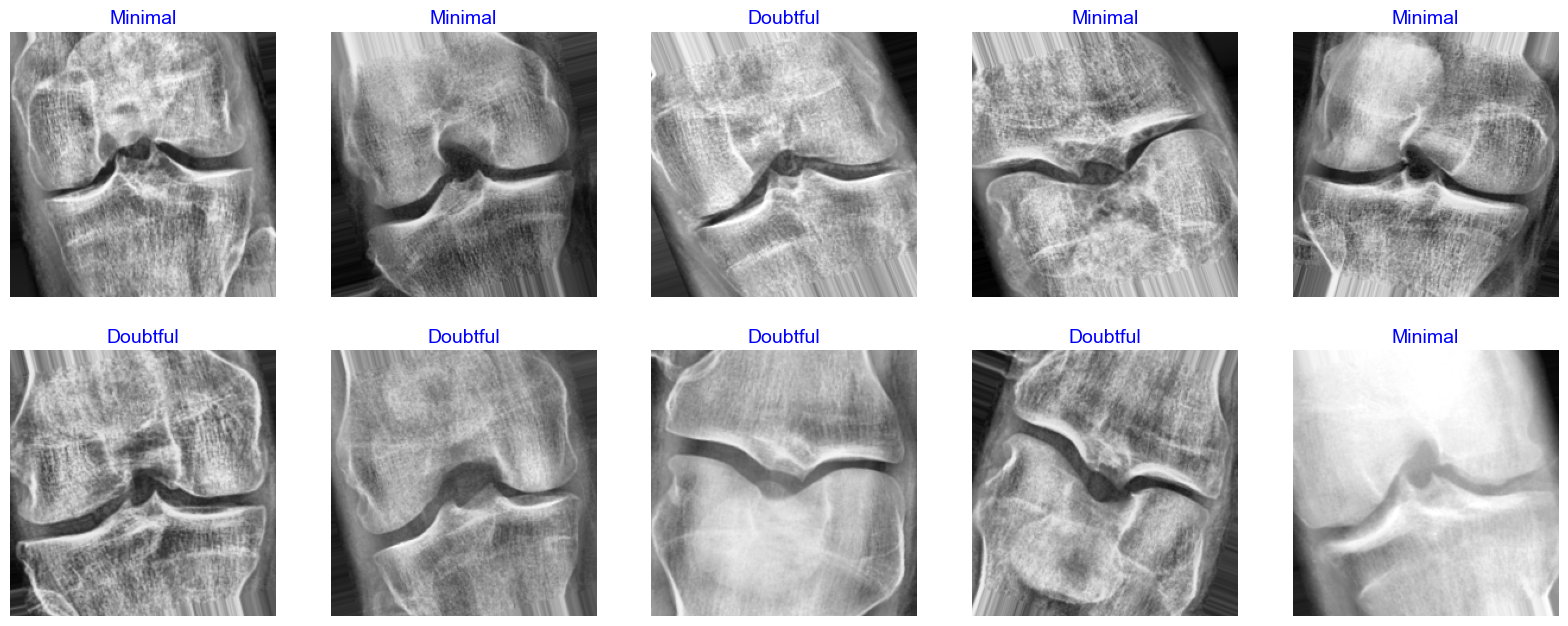

In [12]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length = len(labels)
    
    if length < 10:  # show a maximum of 25 images
        r = length
    else:
        r = 10
    
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    
    plt.show()

# Visualize images without additional preprocessing
show_image_samples(train_gen)


# training

##  efficient net model

In [144]:
img_size[0]

224

In [145]:
img_size[1]

224

In [13]:
# Additional code for model definition, training, and evaluation should go here

# Model definition
from tensorflow.keras import layers

K.clear_session()  # Clear the session
tf.compat.v1.reset_default_graph()

img_shape = (img_size[0], img_size[1], 3)
model_name = "ResNet50"
# base_model = tf.keras.applications.efficientnet.EfficientNetB5(
base_model = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=img_shape, pooling="max"
)

# Freeze most of the base model layers
base_model.trainable = False

# Fine-tune the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(
    256,
    kernel_regularizer=regularizers.l2(l=0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation="relu",
)(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(len(list_of_classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [156]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)

# Print the test accuracy
print("Test accuracy:", test_acc)

743/743 [==============================] - 43s 49ms/step - loss: 12.5797 - accuracy: 0.6003
Test accuracy: 0.6002691984176636


In [157]:
epochs=10
# ask_epoch=10
# ask=LR_ASK(model, epochs,  ask_epoch)
# callbacks=[ask]

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, #callbacks=callbacks,  
                  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/10
32/32 [==============================] - 28s 544ms/step - loss: 8.6456 - accuracy: 0.5560 - val_loss: 10.0757 - val_accuracy: 0.4740
Epoch 2/10
32/32 [==============================] - 19s 591ms/step - loss: 7.2597 - accuracy: 0.5760 - val_loss: 7.3391 - val_accuracy: 0.5781
Epoch 3/10
32/32 [==============================] - 19s 599ms/step - loss: 6.3649 - accuracy: 0.5710 - val_loss: 6.2841 - val_accuracy: 0.5397
Epoch 4/10
32/32 [==============================] - 19s 605ms/step - loss: 5.6910 - accuracy: 0.5670 - val_loss: 6.6717 - val_accuracy: 0.4274
Epoch 5/10
32/32 [==============================] - 19s 600ms/step - loss: 5.2228 - accuracy: 0.5620 - val_loss: 4.9678 - val_accuracy: 0.5534
Epoch 6/10
32/32 [==============================] - 19s 602ms/step - loss: 4.7308 - accuracy: 0.5930 - val_loss: 4.5615 - val_accuracy: 0.5151
Epoch 7/10
32/32 [==============================] - 19s 602ms/step - loss: 4.2864 - accuracy: 0.6070 - val_loss: 4.6731 - val_accuracy: 0.498

In [149]:

# ask_epoch=10
# ask=LR_ASK(model, epochs,  ask_epoch)
# callbacks=[ask]

history=model.fit(x=train_gen,  epochs=20, verbose=1, #callbacks=callbacks,  
                  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=9)

Epoch 9/20
63/63 [==============================] - 29s 449ms/step - loss: 1.6181 - accuracy: 0.6295 - val_loss: 1.5523 - val_accuracy: 0.5808
Epoch 10/20
63/63 [==============================] - 28s 448ms/step - loss: 1.4808 - accuracy: 0.6185 - val_loss: 1.4573 - val_accuracy: 0.5534
Epoch 11/20
63/63 [==============================] - 29s 450ms/step - loss: 1.3511 - accuracy: 0.6325 - val_loss: 1.3142 - val_accuracy: 0.5644
Epoch 12/20
63/63 [==============================] - 28s 448ms/step - loss: 1.2473 - accuracy: 0.6300 - val_loss: 1.2060 - val_accuracy: 0.5918
Epoch 13/20
63/63 [==============================] - 28s 449ms/step - loss: 1.1494 - accuracy: 0.6475 - val_loss: 1.1677 - val_accuracy: 0.5644
Epoch 14/20
63/63 [==============================] - 29s 450ms/step - loss: 1.1036 - accuracy: 0.6190 - val_loss: 1.0903 - val_accuracy: 0.5507
Epoch 15/20
63/63 [==============================] - 29s 450ms/step - loss: 1.0271 - accuracy: 0.6355 - val_loss: 1.0384 - val_accuracy: 

# post training

## testing

743/743 [==============================] - 36s 44ms/step
there were 300 errors in 743 tests for an accuracy of  59.62


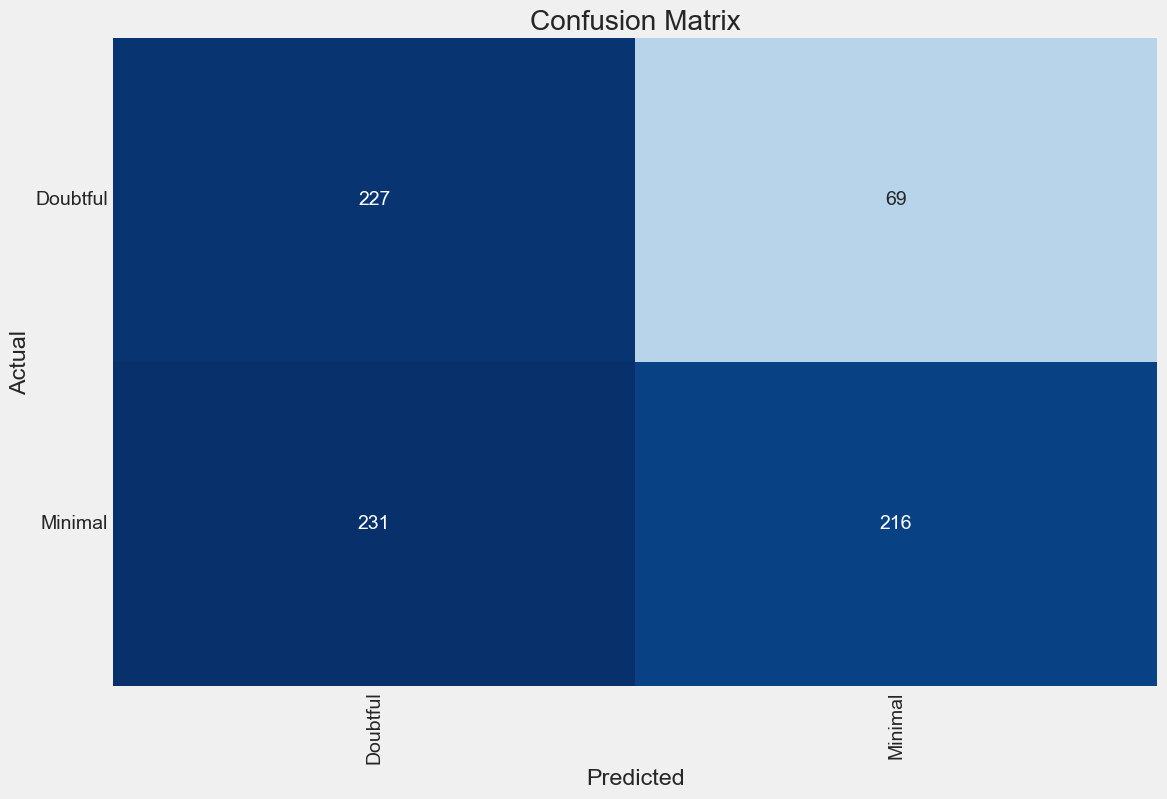

Classification Report:
----------------------
               precision    recall  f1-score   support

    Doubtful     0.4956    0.7669    0.6021       296
     Minimal     0.7579    0.4832    0.5902       447

    accuracy                         0.5962       743
   macro avg     0.6268    0.6251    0.5961       743
weighted avg     0.6534    0.5962    0.5949       743



In [150]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)


## graph 

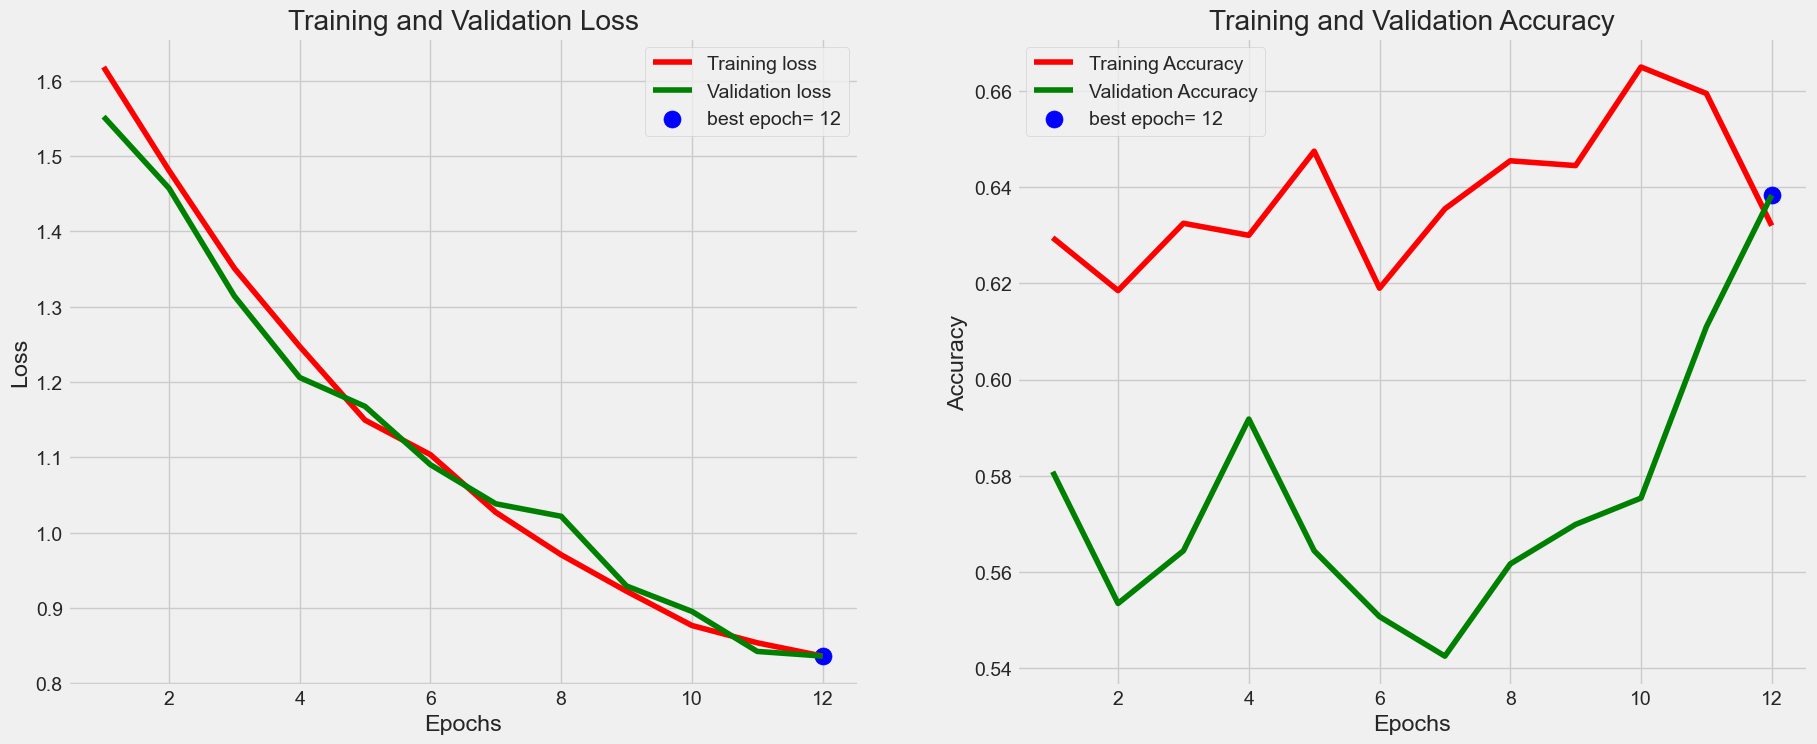

In [151]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)


# end

In [123]:
print (test_df['labels'].value_counts())

Healthy     639
Minimal     447
Doubtful    296
Moderate    223
Severe       51
Name: labels, dtype: int64


In [124]:
max_samples=51
# since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=51
column='labels'
test_df= trim(test_df, max_samples, min_samples, column)


# n=52 # number of samples in each class
# working_dir=r'./' # directory to store augmented images
# img_size=IMGSZ # size of augmented images
# test_df=balance(test_df, n, working_dir, img_size) 

print("")
print (test_df['labels'].value_counts())




t_and_v_gen = ImageDataGenerator()
test_gen = t_and_v_gen.flow_from_dataframe(
    test_df,
    x_col="filepaths",
    y_col="labels",
    target_size=img_size,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    batch_size=test_batch_size,
    preprocessing_function=preprocessing_function,
)

after trimming, the maximum samples in any class is now  51  and the minimum samples in any class is  51
Initial length of dataframe is  255
Found 51 validated image filenames.      for class            Healthy             creating   1   augmented images 
Found 51 validated image filenames.      for class            Doubtful            creating   1   augmented images 
Found 51 validated image filenames.      for class            Minimal             creating   1   augmented images 
Found 51 validated image filenames.      for class            Moderate            creating   1   augmented images 
Found 51 validated image filenames.      for class             Severe             creating   1   augmented images 
Total Augmented images created=  5
Length of augmented dataframe is now  260

Healthy     52
Doubtful    52
Minimal     52
Moderate    52
Severe      52
Name: labels, dtype: int64
Found 260 validated image filenames belonging to 5 classes.


## balanced testing

4/4 [==============================] - 4s 1s/step
there were 133 errors in 260 tests for an accuracy of  48.85


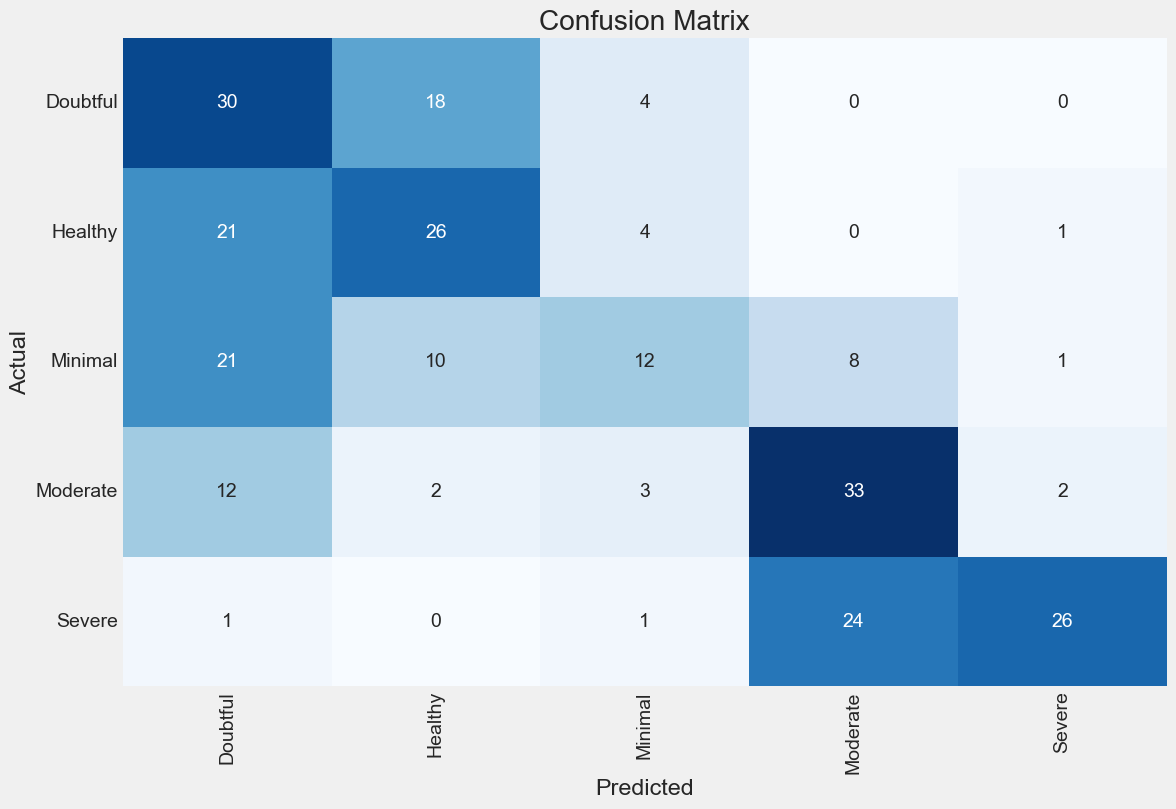

Classification Report:
----------------------
               precision    recall  f1-score   support

    Doubtful     0.3529    0.5769    0.4380        52
     Healthy     0.4643    0.5000    0.4815        52
     Minimal     0.5000    0.2308    0.3158        52
    Moderate     0.5077    0.6346    0.5641        52
      Severe     0.8667    0.5000    0.6341        52

    accuracy                         0.4885       260
   macro avg     0.5383    0.4885    0.4867       260
weighted avg     0.5383    0.4885    0.4867       260



In [125]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)
